In [ ]:
%run Financial_data.ipynb

In [8]:
# ────────────────────────────────────────────────────────────────
#  BLACK-LITTERMAN: bygg views från färdiga matriser (weekly)
# ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import risk_models, black_litterman, BlackLittermanModel, EfficientFrontier


# ▸ 0. SÄKERHETSKOLL  --------------------------------------------------


# missing = [name for name in needed if name not in globals()]
# if missing:
#     raise RuntimeError(
#         f"Variabler saknas i minnet: {missing}. "
#         "Kör först financial_data.ipynb så att de skapas."
#     )

# ▸ 1. SKAPA closing_prices-matris från dina DataFrames  --------------
def to_series(df, name):
    s = df.set_index("Date")["Close"]
    s.index = pd.to_datetime(s.index)
    return s.rename(name)

closing_prices = pd.concat(
    [
        to_series(df_bnd,  "BND"),
        to_series(df_gld,  "GLD"),
        to_series(df_hodl, "HODL.PA"),
        to_series(df_spy,  "SPY"),
    ],
    axis=1,
).sort_index()
closing_prices = closing_prices.dropna()
closing_prices


,BND,GLD,HODL.PA,SPY
Date,,,,
2022-05-05,68.541466,175.130005,15.010000,396.066406
2022-05-06,68.251228,175.419998,15.010000,393.702301
2022-05-09,68.559616,172.880005,9.900000,381.097076
2022-05-10,68.759155,171.419998,9.870000,381.977539
2022-05-11,68.994965,172.820007,9.870000,375.909454
...,...,...,...,...
2025-05-14,72.040001,293.160004,16.712900,587.590027
2025-05-15,72.430000,297.839996,16.450100,590.460022
2025-05-16,72.480003,294.239990,16.719801,594.200012


OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])
Views: {'SPY': np.float64(0.00020949917742136393), 'BND': np.float64(-6.906525377352843e-05), 'GLD': np.float64(-6.895230232647852e-05), 'HODL.PA': np.float64(-0.0009803857556591677)}
Conf: [np.float64(0.023512829599843358), np.float64(0.02844530895110769), np.float64(0.011734474044609545), np.float64(0.05357438448613782)]

OPTIMERAD PORTFÖLJ (weekly BL):
  BND    :  66.2 %
  GLD    :  10.6 %
  HODL.PA:   1.3 %
  SPY    :  21.9 %


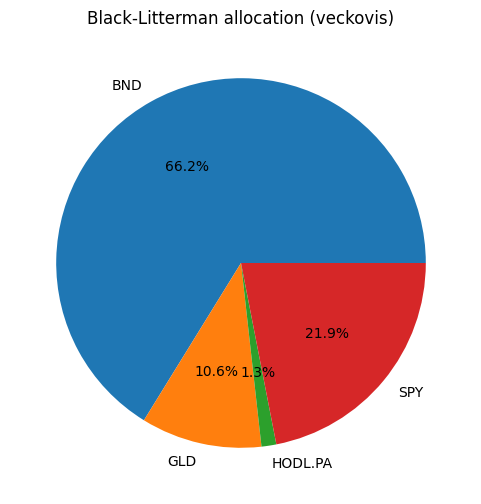

In [9]:
mcaps = {
    "SPY":    46_483_000_000_000, 
    "BND":   140_700_000_000_000,
    "GLD":    22_335_000_000_000,
    "HODL.PA": 2_970_000_000_000,
}

cov   = risk_models.CovarianceShrinkage(closing_prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(closing_prices["SPY"])
pi    = black_litterman.market_implied_prior_returns(mcaps, delta, cov)

bl = BlackLittermanModel(
    cov,
    pi=pi,
    absolute_views=viewdict,
    omega="idzorek",
    view_confidences=confidences,
    risk_aversion=delta,
)
ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov())
ef.max_sharpe()
weights = ef.clean_weights()

print(weights)

print("Views:", viewdict)
print("Conf:", confidences)

print("\nOPTIMERAD PORTFÖLJ (weekly BL):")
for k, v in weights.items():
    print(f"  {k:7s}: {v*100:5.1f} %")

# (valfritt) visa fördelningen
pd.Series(weights).plot.pie(figsize=(6,6), autopct='%1.1f%%')
plt.ylabel("")
plt.title("Black-Litterman allocation (veckovis)")
plt.show()


In [10]:
closing_prices = closing_prices.reset_index()
closing_prices['Date'] = closing_prices['Date'].dt.strftime('%Y-%m-%d')  # Ensure same format
closing_prices = pd.merge(closing_prices, df_bnd_ml, on=['Date', 'Date'])

In [11]:
from xgb import Trainer
import plotly.graph_objs as go

ASSETS = [df_bnd_ml, df_gld_ml, df_hodl_ml, df_spy_ml]

bnd_trainer = Trainer().fit(df_bnd_ml)
gld_trainer = Trainer().fit(df_gld_ml)
crypto_trainer = Trainer().fit(df_hodl_ml)
spy_trainer = Trainer().fit(df_spy_ml)

trainers = [bnd_trainer, gld_trainer, crypto_trainer, spy_trainer]
tickers = ["BND", "GLD", "HODL.PA", "SPY"]

def calculate_portfolio_returns(n):
    portfolio_returns_over_time = []
    benchmark_returns_over_time = []
    dates = []

    returns = 1.0
    benchmark = 1.0
    
    global weights
    print("Investment period starts at: ", closing_prices['Date'].iloc[n])
    print("Investment period ends at: ", closing_prices['Date'].iloc[len(closing_prices.values)-1])
    for date in range(n, len(closing_prices.values)):
        views, confidences = {}, []
        for i, etf in enumerate(ASSETS):
            mu, conf = trainers[i].predict(etf.iloc[date-8:date])
            views[tickers[i]] = mu
            confidences.append(conf)
        bl = BlackLittermanModel(
            cov,
            pi=pi,
            absolute_views=views,
            omega="idzorek",
            view_confidences=confidences,
            risk_aversion=delta,
        )
        ef = EfficientFrontier(bl.bl_returns(), bl.bl_cov())
        ef.max_sharpe()
        weights = ef.clean_weights()
        
        benchmark_daily_return = (
            ((closing_prices["SPY"].iloc[date] - closing_prices["SPY"].iloc[date - 1]) / closing_prices["SPY"].iloc[date - 1]) * 0.6
            + ((closing_prices["BND"].iloc[date] - closing_prices["BND"].iloc[date - 1]) / closing_prices["BND"].iloc[date - 1]) * 0.4
        )
        benchmark *= (1 + benchmark_daily_return)

        daily_return = sum([((closing_prices[etf].iloc[date] - closing_prices[etf].iloc[date - 1]) / closing_prices[etf].iloc[date - 1]) * weight for etf, weight in weights.items()])
        returns *= (1 + daily_return)

        # portfolio_returns_over_time.append(round((returns-1)*100,2))
        # benchmark_returns_over_time.append(round((benchmark-1)*100,2))
        portfolio_returns_over_time.append(round((returns-1),2))
        benchmark_returns_over_time.append(round((benchmark-1),2))
        dates.append(closing_prices['Date'].iloc[date])

    print("Portfolio returns was: ", round((returns-1)*100,2), "%")
    print("Benchmark was: ", round((benchmark-1)*100,2), "%")
    print("Current weights are: ", weights)

    # Select indices for bubble labels (approx. 12 total)
    step = max(1, len(dates) // 7)
    label_indices = list(range(0, len(dates), step))
    # fig.show()
    fig = go.Figure()

    # Portfolio line and markers (without text labels)
    fig.add_trace(go.Scatter(
        x=dates,
        y=portfolio_returns_over_time,
        mode='lines',
        name='Portfolio',
        line=dict(width=2, color='red'),
        marker=dict(size=6),
        hovertemplate='Date: %{x}<br>Return: %{y:.1%}<extra></extra>'
    ))

    # Benchmark line and markers
    fig.add_trace(go.Scatter(
        x=dates,
        y=benchmark_returns_over_time,
        mode='lines',
        name='Benchmark (60/40 SPY/BND)',
        line=dict(width=2, color='blue'),
        marker=dict(size=6),
        hovertemplate='Date: %{x}<br>Return: %{y:.1%}<extra></extra>'
    ))

    # Add annotations (comment bubbles) for Portfolio values at label indices
    for i in label_indices:
        fig.add_annotation(
            x=dates[i],
            y=portfolio_returns_over_time[i],
            text=f"<b>{portfolio_returns_over_time[i]:.1%}</b>",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=60,  # vertical offset for the text above the point
            bgcolor="rgba(255, 0, 0, 0.7)",  # semi-transparent red bg
            bordercolor="red",
            font=dict(color="white", size=12),
            align="center",
            arrowcolor="red",
            opacity=1,
            captureevents=True
        )

    # Add annotations (comment bubbles) for Benchmark values at label indices
    for i in label_indices:
        fig.add_annotation(
            x=dates[i],
            y=benchmark_returns_over_time[i],
            text=f"<b>{benchmark_returns_over_time[i]:.1%}</b>",
            showarrow=True,
            arrowhead=2,
            ax=0,
            ay=-60,  # vertical offset for text below the point
            bgcolor="rgba(0, 0, 255, 0.7)",  # semi-transparent blue bg
            bordercolor="blue",
            font=dict(color="white", size=12),
            align="center",
            arrowcolor="blue",
            opacity=1,
            captureevents=True
        )

    fig.update_layout(
        title='Portfolio vs Benchmark Cumulative Returns',
        xaxis_title='Date',
        yaxis_title='Cumulative Return',
        yaxis=dict(tickformat=".00%"),
        legend=dict(x=0.01, y=0.99),
        template="plotly_white",
        height=700,
    )

    fig.show()


    return returns-1, benchmark-1


[INFO] Trained regressor — Test MSE: 0.000006
[INFO] Trained regressor — Test MSE: 0.000034
[INFO] Trained regressor — Test MSE: 0.000300
[INFO] Trained regressor — Test MSE: 0.000076


Investment period starts at:  2024-07-25
Investment period ends at:  2025-02-12
Portfolio returns was:  6.08 %
Benchmark was:  7.86 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2023-08-03
Investment period ends at:  2025-02-12
Portfolio returns was:  18.18 %
Benchmark was:  23.87 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2023-09-22
Investment period ends at:  2025-02-12
Portfolio returns was:  20.76 %
Benchmark was:  27.62 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2023-11-09
Investment period ends at:  2025-02-12
Portfolio returns was:  19.42 %
Benchmark was:  26.35 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2024-01-03
Investment period ends at:  2025-02-12
Portfolio returns was:  12.43 %
Benchmark was:  17.89 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2024-02-22
Investment period ends at:  2025-02-12
Portfolio returns was:  12.33 %
Benchmark was:  15.06 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2024-04-12
Investment period ends at:  2025-02-12
Portfolio returns was:  9.43 %
Benchmark was:  12.31 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2024-06-04
Investment period ends at:  2025-02-12
Portfolio returns was:  7.84 %
Benchmark was:  10.28 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2024-07-25
Investment period ends at:  2025-02-12
Portfolio returns was:  6.08 %
Benchmark was:  7.86 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


Investment period starts at:  2024-09-12
Investment period ends at:  2025-02-12
Portfolio returns was:  2.19 %
Benchmark was:  4.36 %
Current weights are:  OrderedDict([('BND', 0.66199), ('GLD', 0.10571), ('HODL.PA', 0.01296), ('SPY', 0.21934)])


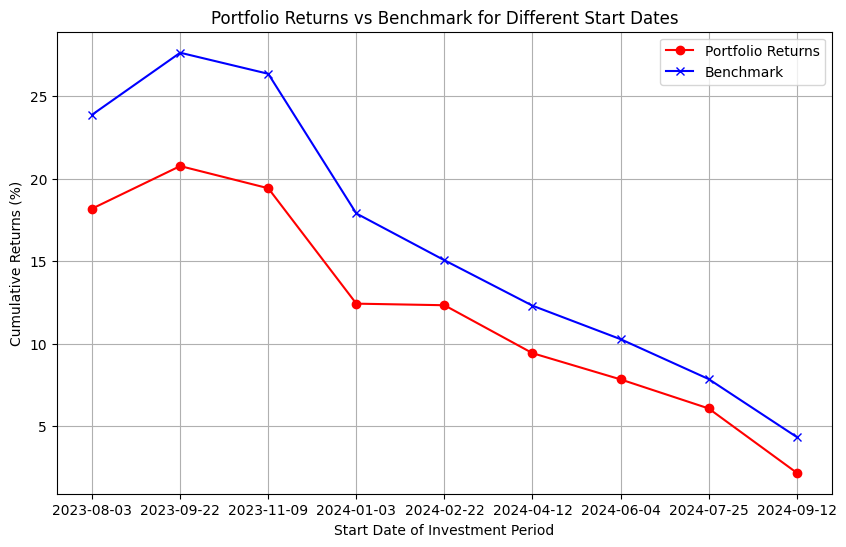

In [12]:
portfolio_returns = []
benchmarks = []
start_dates = []


returns, benchmark = calculate_portfolio_returns(int(80 / 100 * len(closing_prices.values)))

for i in range(45, 90, 5):  # Modify this loop for a range of percentages, using steps of 5%
    n = int(i / 100 * len(closing_prices.values))  # Convert percentage to index position
    returns, benchmark = calculate_portfolio_returns(n)
    portfolio_returns.append(returns*100)
    benchmarks.append(benchmark*100)
    start_dates.append(closing_prices['Date'].iloc[n])

# Now plot the results:
plt.figure(figsize=(10, 6))
plt.plot(start_dates, portfolio_returns, label='Portfolio Returns', marker='o', color='red')
plt.plot(start_dates, benchmarks, label='Benchmark', marker='x', color='blue')

plt.title('Portfolio Returns vs Benchmark for Different Start Dates')
plt.xlabel('Start Date of Investment Period')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(True)
plt.show()